# Data Pre-processing

**Table of contents:**
1. About the pre-processing
2. Importing necessary libraries.
3. Loading the data.
5. Fixing class labels.
6. Look for and remove duplicates.
7. Train-test split.
8. Tweet cleaning and tokenization.

## 1. About the pre-processing

In order to train a machine learning model, we need to pre-process the data. This includes:
- *Stem 1:* Fixing class labels to make them compatible with our algorithms.
- *Step 2:* Removing duplicates.
- *Step 3:* Splitting the data into training and testing sets.
- *Step 4:* Make the text lowercase, then remove digits, punctuation, usernames, and links. These are all features of a Tweet that aren’t useful in determining sentiment.
- *Step 5:* Tokenize. Standard NLP technique, we break the sentence up into a list of words (“tokens”).
- *Step 6:* Remove stopwords and common words. Stopwords hold little semantic meaning, while common words don’t help determine sentiment and reduce the signal of more unique words.
- *Step 7:* Lemmatize. Lemmatization is a way of normalising our words so similar words are classed as the same, e.g. “years” and “yearly” both become “year”.

<img src="../data/tweet_processing.png" alt="Data processing" title="Data processing" width="400">

## 2. Importing necessary libraries.

In [10]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import random


from wordcloud import WordCloud
import nltk # natural language toolkit
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import itertools
from collections import Counter



from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tesal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tesal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tesal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Loading the data

The data was obtained from Edward Qian on Kaggle: https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [11]:
##load data into mainframe
df = pd.read_csv("../data/twitter_sentiment_data.csv")
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


## 4. Fixing class labels

First step is to change the sentiment labels, adding 1 to each label (then we will not have negative values) — this helps with KMeans clustering, which we’ll use later. After this, we will have:
- Class 0: "Anti"
- Class 1: "Neutral"
- Class 2: "Pro"
- Class 3: "News"

In [12]:
df['sentiment'] = df['sentiment'].apply(lambda x :x+1)

print(f"Max: {df.sentiment.max()},", f"Min: {df.sentiment.min()}") # max should == 3, min == 0
df.head()

Max: 3, Min: 0


,sentiment,message,tweetid
0,0,@tiniebeany climate change is an interesting h...,792927353886371840
1,2,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,2,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,2,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,3,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


## 5. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is essential for understanding, cleansing, and deriving insights from datasets. It aids in identifying data quality issues, selecting relevant features, detecting patterns and validating assumptions.

First, we shuffle our dataframe and print a few tweets to see if we can identify any patterns or use of obvious words.

In [13]:
shuffled_df = df.sample(frac = 1)

n = 20
for row in range(0, n):
    print('label = ', shuffled_df['sentiment'].iloc[row])
    print(shuffled_df['message'].iloc[row], end = "\n\n  \n\n")

label =  2
☹️global warming is real ppl https://t.co/Ty9kKPYDAp

  

label =  3
Some Democratic lawmakers are moving to organize around climate change on the state level.

https://t.co/x7YtaLkk1h… https://t.co/pCogridxfl

  

label =  2
We have a president elect that does not believe in climate change. This is dangerous to humanity and our planet.

  

label =  3
RT @ManipadmaJena: Will climate change push the Superbug to speard more rapidly in India? Here's what experts said @ManipadmaJena 
#Antibioâ€¦

  

label =  2
RT @newscientist: The epic size of #HurricaineIrma is fuelled by global warming https://t.co/ixxrSUPOCX https://t.co/fLEvGo3qPM

  

label =  2
RT @siemens_press: Joe Kaeser op-ed in @TIME: «To beat climate change, digitalize the electrical world» https://t.co/B19caeZpT3 #FortuneTim…

  

label =  2
RT @alfromct: EPA Pruitt, incompetent plagiarist, says CO2 not a contributor to global warming. NASA &amp; NOAA say otherwise.  https://t.co/6S…

  

label =  2
Btw there are

We can easily identify some words that could be deleted, like "RD" or the tweet URL.

Secondly we will inspect the class distribution.

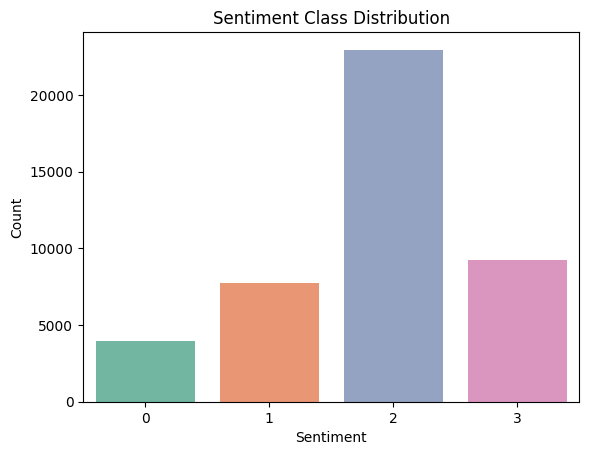

In [14]:
sns.countplot(data=df, x='sentiment', palette="Set2", legend=False, hue='sentiment')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

As we can see above, the dataset is imbalanced, with the majority of tweets being "2", pro. This is important to keep in mind when training our model.

After preprocessing, we will continue with EDA using wordclouds to visualize the most common words in each class.

## 6. Train-test split
- Train: 75%
- Validation: 5%
- Test: 20%

In [15]:
X = df.drop(columns = 'sentiment')
y = df['sentiment']

# Getting train
X_train, X_test_pre, y_train, y_test_pre = train_test_split(X, y, test_size = 0.25, random_state = 100)

# Pulling a validation set too 
X_test, X_val, y_test, y_val = train_test_split(X_test_pre, y_test_pre, test_size = 0.2, random_state = 100)

# Check datasets
print('Overall data size = ', df.shape[0], end = '\n\n')



d_sets = {'train' : (X_train, y_train),
         'test' : (X_test,y_test),
         'val' : (X_val,y_val)}

for k,v in d_sets.items():
    print(f"- Metrics for {k} -")
    print('number of rows:', v[0].shape[0])
    print('fraction:', round(v[0].shape[0]/df.shape[0], 2))
    print('X-y match?:', v[0].shape[0]==len(v[1]), end = '\n\n')

# Save datasets
for k,v in d_sets.items():
    d_set = v[0].copy()
    d_set['target'] = v[1]

    # save without index
    d_set.to_csv(f'../data/{k}.csv', index = False)
    print(k, 'saved')

Overall data size =  43943

- Metrics for train -
number of rows: 32957
fraction: 0.75
X-y match?: True

- Metrics for test -
number of rows: 8788
fraction: 0.2
X-y match?: True

- Metrics for val -
number of rows: 2198
fraction: 0.05
X-y match?: True

train saved
test saved
val saved


## 7- Defining pre-processing functions

We will define some stopmswords and a function to clean the tweets. **Stopwords** are common words like "the", "is", "and" that often don't carry significant meaning in text analysis. 

We will also define a lemanizer to normalize words. **Lemmatization** is the process of reducing words to their base or root form. It helps in reducing words to their canonical form, which can be useful for tasks like text classification or sentiment analysis. 

In [16]:
# Define stopwords and lemmatizer
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)  # add punctuation symbols to stopwords: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
stpwrd.extend(['rt', 'co', 'https', 'http', 'amp', 'us'])  # add common twitter terms to stopwords
commwords = ['climate', 'change', 'global', 'warming','like', 'ðÿ', 'il', 'le', 'gt']
stpwrd.extend(commwords) # add common words to stopwords

lem = WordNetLemmatizer()

In [17]:
def regex_clean(txt: str, regex: str):
    """Remove any text matching a RegEx pattern.

    Args:
        txt (str): A text string that you want to parse and remove matches.
        regex (str): A text string of the regex pattern you want to match.

    Returns:
        str: The same txt string with the matches removes
    """
    return " ".join(re.sub(regex, " ", txt).split())

In [18]:
def remove_stpwrds(text: str):
    """Clean up a tweet.

    First, the function will make the text lowercase, remove mentions, links, punctuation, numbers, and single characters.
    Then, it will tokenize the text and remove stopwords. Finally, it will lemmatize the words.

    Args:
        text (str): A tweet that you want to parse and remove matches

    Returns:
        str: Cleaned up string - tokenized & stemmed!
    """
    
    # 1. Pre Token Cleaning
    text = text.lower()  # make lowercase
    text = regex_clean(text, r'(?:)@[A-Za-z0-9\-\.\_]+(?:)')  # remove mentions
    text = regex_clean(text, r'(?:(?:http?|https?|ftp):\/\/)\S+')  # remove links
    text = regex_clean(text, r"[^\w\s]" )  # remove punctuation
    text = regex_clean(text, r"\d")  # remove numbers
    text = regex_clean(text, r"\b\w\b")  # remove single characters
    text = regex_clean(text, r"(\S+|\b)[^a-zA-Z\s]\S+")  # remove non-alphabetic chars and non-english words
    text = regex_clean(text, r"[^a-z]+")  # remove more non-alphabetic chars and non-english words

    # 2. Tokenization
    text = word_tokenize(text)
    
    # 3. Token cleaning
    text = [word for word in text if word not in stpwrd]  # remove stopwords
    text = [lem.lemmatize(word) for word in text]  # lemmatize words
    
    return text

In [19]:
def df_cleaner(df: pd.DataFrame):
    """Clean and summarize a DataFrame containing tweet data.
    
    It will filter out rows with no words in the tweet text and provide some summary statistics about the dataset. 

    Args:
        df (pd.DataFrame): _description_
        pr (bool, optional): 

    Returns:
        _type_: _description_
    """
    """# Filter DataFrame to remove rows with no words
    words = df[df['token_len'] != 0]

    # Calculate summary statistics
    total_tweets = df.shape[0]
    tweets_with_words = words.shape[0]
    tweets_with_no_words = total_tweets - tweets_with_words
    dropped_tweets = tweets_with_no_words
    
    summary_stats = {
        'total_tweets': total_tweets,
        'tweets_with_words': tweets_with_words,
        'tweets_with_no_words': tweets_with_no_words,
        'dropped_tweets': dropped_tweets
    }"""

        
    no_word_mask = df['token_len'] == 0
    no_words = df[no_word_mask]
    
    word_mask = df['token_len'] != 0
    words = df[word_mask]
    
    print(f'{words.shape[0]} tweets have words, {no_words.shape[0]} have no words')
    print(f'{no_words.shape[0]} tweets dropped', end = '\n\n')
    print(no_words.target.value_counts(), end = '\n\n')

    #Token Lengths
    print("Min number of tokens: ", df['token_len'].min())
    print("Max number of tokens: ", df['token_len'].max())
    return words

In [20]:
# Example:
remove_stpwrds("RT @User: This is what 800,000 years of climate change looks like https://t.co/XXXXXXXX")

['year', 'look']

## 8. Pre-processing

In [22]:
# read train test val data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
val = pd.read_csv('../data/val.csv')

In [23]:
train['tokens'] = train['message'].apply(remove_stpwrds)
train['token_len'] = train['tokens'].apply(len)

train = df_cleaner(train)

train.head()

32822 tweets have words, 135 have no words
135 tweets dropped

target
1    105
2     20
0      8
3      2
Name: count, dtype: int64

Min number of tokens:  0
Max number of tokens:  21


,message,tweetid,target,tokens,token_len
0,"I was out in this cold snap tonight, and my ch...",957109125804109824,1,"[cold, snap, tonight, cheek, pink, look, real,...",9
1,RT @SenSanders: We have a president-elect who ...,798291253452386306,2,"[president, elect, believe, million, people, g...",8
2,RT @SaveLiberty1st: Climate Change is really a...,790586704050556928,0,"[really, redistribution, scale, leftist, want,...",7
3,8 Little Things You Can Do About Global Warming,644967613240619011,2,"[little, thing]",2
4,"RT @RedTRaccoon: As 1,000s march to fight for ...",858387298177634305,2,"[march, fight, environment, combat, please, wa...",11


In [24]:
def untokener(tokens: list):
    """Stitch tokens back together into a string for TF-IDF Vectorizer.

    TF-IDF Vectorizer requires a string input, so this function will join the tokens back together into a string.
    The TF-IDF Vectorizer will then tokenize the string again.

    Args:
        tokens (list): list of tokens (strings) from a tweet.

    Returns:
        str: strink of tokens joined by a space.
    """
    s = ' '
 
    s = s.join(tokens)
    return s

In [25]:
#apply untoking
train['clean_message'] = train['tokens'].apply(untokener)
train.head()

,message,tweetid,target,tokens,token_len,clean_message
0,"I was out in this cold snap tonight, and my ch...",957109125804109824,1,"[cold, snap, tonight, cheek, pink, look, real,...",9,cold snap tonight cheek pink look real cute anti
1,RT @SenSanders: We have a president-elect who ...,798291253452386306,2,"[president, elect, believe, million, people, g...",8,president elect believe million people going s...
2,RT @SaveLiberty1st: Climate Change is really a...,790586704050556928,0,"[really, redistribution, scale, leftist, want,...",7,really redistribution scale leftist want stifl...
3,8 Little Things You Can Do About Global Warming,644967613240619011,2,"[little, thing]",2,little thing
4,"RT @RedTRaccoon: As 1,000s march to fight for ...",858387298177634305,2,"[march, fight, environment, combat, please, wa...",11,march fight environment combat please watch ca...


## 9. More EDA: Word Clouds

Word clouds are a great way to visualize the most common words in each class. We will create a word cloud for each class to see if we can identify any patterns.

In [26]:
counts = {}

for cl in range(0, 4):
    clss_df = train[train['target'] == cl]

    t_c = Counter()
    clss_df['tokens'].apply(t_c.update)

    k = "class_" + str(cl)
    counts[k] = t_c

print(counts.keys())

dict_keys(['class_0', 'class_1', 'class_2', 'class_3'])


In [27]:
# Palette function
def twitter_colours(word, font_size, position,orientation,random_state=None, **kwargs):
    return random.choice(['#1DA1F2','#56B9F6','#72C5F8','#80CBF9','#8ED0F9','#96D3FA','#9DD6FA','#ABDCFB', '#C7E8FC','#FFFFFF'])

In [28]:
def cloudword(cl_keys):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for i, cl_key in enumerate(cl_keys):
        wc = WordCloud(width=400, height=400, max_words=100, background_color="#16202B", color_func=twitter_colours).generate_from_frequencies(counts[cl_key])
        row = i // 2
        col = i % 2
        axs[row, col].imshow(wc, interpolation="bilinear")
        axs[row, col].set_title(f'Class: {cl_key}')
        axs[row, col].axis("off")
        
    plt.tight_layout()
    plt.show()

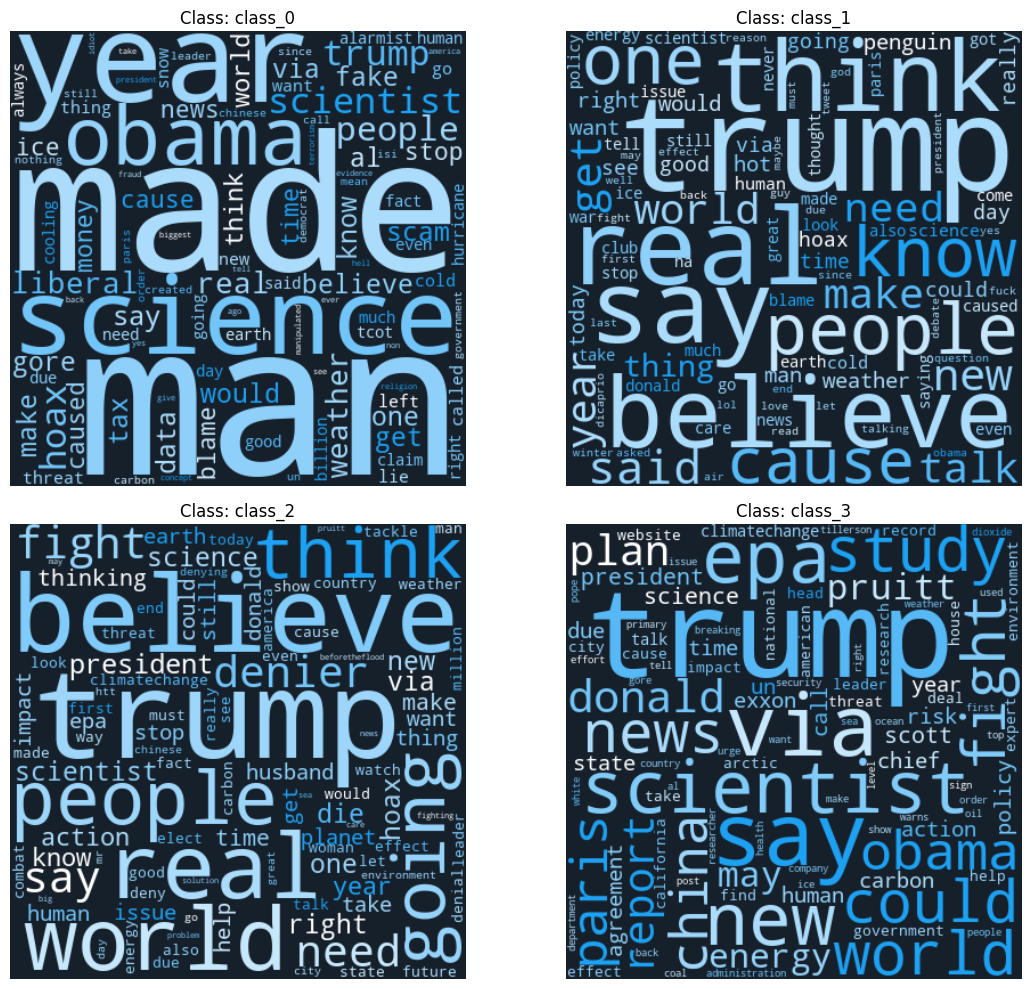

In [22]:
cloudword(counts.keys())

# Remember:
# Class 0 = "Anti"
# Class 1 = "Neutral"
# Class 2 = "Pro"
# Class 3 = "News"

## 10. Resampling

While we have pre-processed the data, it is still severely imbalanced - let's fix that.

But first, let's see how the classes are distributed.

In [29]:
counts = pd.DataFrame(train.groupby('target')['message'].count())
total = counts.message.sum()

counts['percentage'] = round(100* (counts['message']/total))
counts['label'] = counts.index
print(counts)

        message  percentage  label
target                            
0          3025         9.0      0
1          5736        17.0      1
2         17194        52.0      2
3          6867        21.0      3


Text(0.5, 1.0, 'Class Imbalance of Training Data')

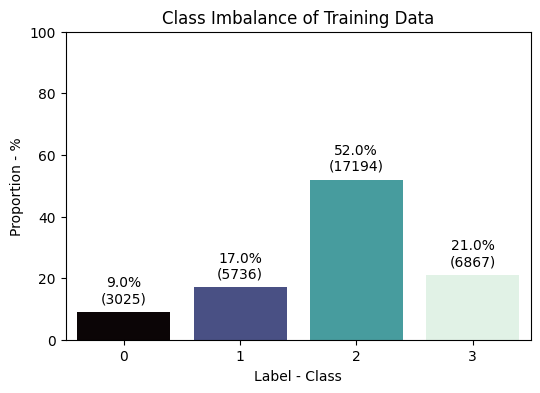

In [30]:
plt.figure(figsize=(6,4))
g = sns.barplot(x = 'label', y = 'percentage',  data = counts, palette = 'mako', legend=False, hue='label')
g.set_ylim(0,100)

c = 0

for p in g.patches:
    txt = str(p.get_height().round()) + '%\n(' + str(counts.message[c]) + ')'
    txt_x = p.get_x() + 0.4
    txt_y = p.get_height() + 3
    g.text(txt_x, txt_y, txt, ha = 'center')
    
    c += 1

plt.ylabel('Proportion - %')
plt.xlabel('Label - Class')
plt.title('Class Imbalance of Training Data')

We'll split the classes into different dataframes for resampling.

In [31]:
# split these into classes
resamp = train.copy()

resamp_anti = resamp[resamp['target'] == 0]
resamp_neut = resamp[resamp['target'] == 1]
resamp_pro = resamp[resamp['target'] == 2]
resamp_news = resamp[resamp['target'] == 3]

frames = [resamp_pro, resamp_neut, resamp_anti, resamp_news]

for frame in frames:
    print(frame.shape[0])

17194
5736
3025
6867


We want all classes to be at 10,000. For that we will do:

1. Downsample - Class 2 (Pro)

2. Upsample - Classes 0,1,3 (Anti, Neutral, News)

### 10.1. Downsample

In [32]:
resamp_pro = resample(resamp_pro, replace = False, n_samples = 10000)
frames = [resamp_pro, resamp_neut, resamp_anti, resamp_news]

In [33]:
count_down = pd.concat(frames)

dcounts = pd.DataFrame(count_down.groupby('target')['message'].count())
total = dcounts.message.sum()

dcounts['percentage'] = round(100* (dcounts['message']/total))
dcounts['label'] = dcounts.index
print(dcounts)

        message  percentage  label
target                            
0          3025        12.0      0
1          5736        22.0      1
2         10000        39.0      2
3          6867        27.0      3


Text(0.5, 1.0, 'Class Imbalance of Training Data')

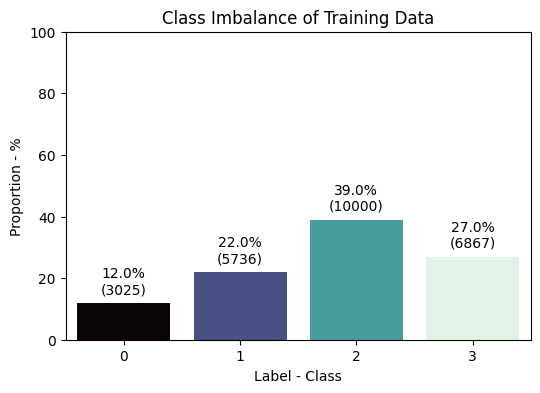

In [34]:
plt.figure(figsize=(6, 4))
g = sns.barplot(x = 'label', y = 'percentage',  data = dcounts, palette = 'mako', legend=False, hue='label')
g.set_ylim(0,100)

c = 0

for p in g.patches:
    txt = str(p.get_height().round()) + '%\n(' + str(dcounts.message[c]) + ')'
    txt_x = p.get_x() + 0.4
    txt_y = p.get_height() + 3
    g.text(txt_x, txt_y, txt, ha = 'center')
    
    c += 1

plt.ylabel('Proportion - %')
plt.xlabel('Label - Class')
plt.title('Class Imbalance of Training Data')

### 10.2. Upsample

going to use the empirical data itself as 'distribution' to sample from - this assumes that the empirical distribution is the same as the actual distribution - https://stackoverflow.com/questions/24208536/generating-random-number-for-a-distribution-of-a-real-data

In [35]:
# Distribution function
def get_len_dist(cdf):
    data = list(cdf.token_len)
    return data

In [36]:
# Plotting Function
def gen_len_distplot(df, num):
    cnt = Counter()
    
    df[['token_len']].apply(cnt.update)
    plt.figure(num)
    sns.countplot(df.token_len)
    print(cnt)

create token buckets for a range of lengths

In [37]:
def get_token_buckets(df):
    word_ranges = [(1, 6), (6, 11), (11, 16), (16,50)] ##high cap on last one to be more of a 16+ category

    buck_dict = {}

    for limits in word_ranges:
        lim_df = df[(df.token_len >= limits[0]) & (df.token_len < limits[1])]
        s = ''
    
        for retokes in lim_df['clean_message']:
            s += retokes
            s += ' '
    
        lim_tokens = word_tokenize(s) 
        
        buck_dict[limits] = lim_tokens
        
    return buck_dict

In [38]:
neut_dict = get_token_buckets(resamp_neut)
#print(neut_dict[(1,6)])
#print(neut_dict[(6,11)])
#print(neut_dict[(11,16)])
#print(neut_dict[(16,50)])

Generate series of new lengths for upsampled data, from len distribution

make a synthetic tweet using a randomly genned length and the correspondinding bucket

In [39]:
def artificial_tweet(to_len, buckets):
    # Determine bucket to pull from
    
    for lims in buckets.keys():
        if to_len >= lims[0] and to_len < lims[1]:
            curr_buck = buckets[lims]
    
    # Pull x amount of words from said bucket = 
    new_tokens = []
    
 #   For i in range(to_len):
    return random.choices(curr_buck, k = to_len)

In [40]:
print(artificial_tweet(8, neut_dict))

['weatherman', 'think', 'degree', 'complex', 'comedy', 'hiring', 'controlled', 'weather']


Apply steps into one function, goes through each class data frame and adds rows until it is new length

In [41]:
def upsample_tweets(raw_df, nu_len, pr = True):
    assert(raw_df.shape[0] < nu_len), "this won't work if the new length is shorter than the original!"
    assert(raw_df.target.min() == raw_df.target.max()), "this only works on data that is labelled as the same - pls filter"
    
    # confirm df label
    label = raw_df.target.min() ##target, check 1/7
    if pr:
        print(f'proceeding with data for class {label}')
    
    df = raw_df.copy()  # gen copy
    # since we are making fake tweets - artificial data, we're going to create a column that tracks the authenticity
    df['is_authentic'] = 1
        
    # first - get lengths of all tweets - to randomly select from - distribution of lengths
    lengths = get_len_dist(df)
    if pr:
        print('lengths got')
    # then we generate our buckets
    bucket_dict = get_token_buckets(df)
    if pr:
        print('buckets made')
    
    # now we have our two components - now we can construct a series of artifical tweets and append to the data frame
    #- upsample!
    ###new length 
    to_add = nu_len - df.shape[0]
    if pr:
        print(f'adding {to_add} rows, entering appending loop')
    
    for row in range(to_add):
        
        if row%1000 == 0 and pr:
            print(row)
        
        ##genning new row, start with the token length
        fake_len = random.choice(lengths)
        ##gen fake tokens - our articial tweet function pulls from 
        #the appropriate bucket depending on the length of our tweet
        fake_tokens = artificial_tweet(fake_len, bucket_dict)
        ##tokens, token_len - check 3/7
        ##might as well gen rest of row now, the retoke field
        fake_retoke = untokener(fake_tokens)
        #untokener - check 4/7
        
        ###message, tweetid and is_authentic are hard coded - check 7/7
        app_dict = {'message': 'SYNTHETIC DATA',
                   'tweetid' : np.nan,
                   'target' : label,
                   'tokens' : fake_tokens,
                   'token_len' : fake_len,
                   'clean_message' : fake_retoke,
                   'is_authentic' : 0}
        
        df = df._append(app_dict, ignore_index = True)
        #df = df.concat(app_dict, ignore_index = True)
    if pr:
        print('... done')
    return df

In [42]:
# upsample all the minority classes
upped_dict = {}
for minor, key in [(resamp_anti,'anti'), (resamp_neut, 'neut'), (resamp_news,'news')]:
    upped_dict[key] = upsample_tweets(minor, 10000)

proceeding with data for class 0
lengths got
buckets made
adding 6975 rows, entering appending loop
0
1000
2000
3000
4000
5000
6000
... done
proceeding with data for class 1
lengths got
buckets made
adding 4264 rows, entering appending loop
0
1000
2000
3000
4000
... done
proceeding with data for class 3
lengths got
buckets made
adding 3133 rows, entering appending loop
0
1000
2000
3000
... done


In [43]:
resamp_pro['is_authentic'] = 1
frames = [resamp_pro, upped_dict['anti'], upped_dict['neut'], upped_dict['news']]
for frame in frames:
    print(frame.shape[0])

10000
10000
10000
10000


Checking how the upsampled data looks - length distributions

Counter({8: 464, 9: 415, 7: 391, 10: 345, 6: 316, 5: 231, 11: 205, 4: 170, 3: 143, 12: 124, 2: 71, 1: 60, 13: 52, 14: 25, 15: 9, 16: 3, 17: 1})
Counter({8: 1529, 7: 1335, 9: 1316, 10: 1195, 6: 1005, 5: 779, 11: 707, 4: 561, 3: 448, 12: 417, 2: 240, 1: 202, 13: 137, 14: 82, 15: 37, 16: 8, 17: 2})


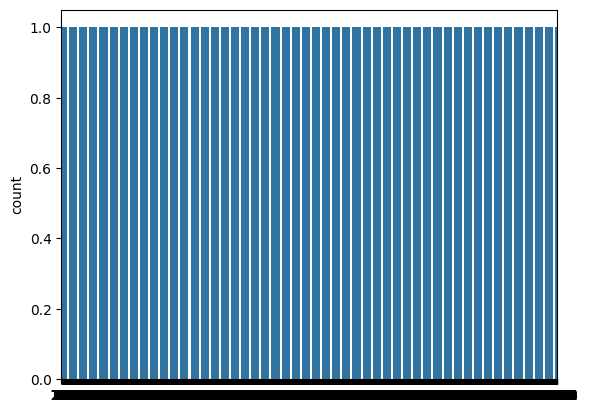

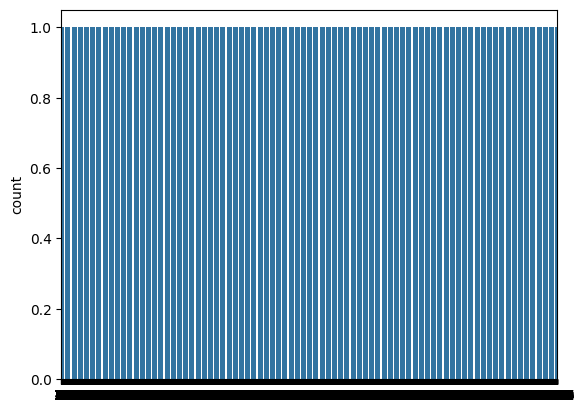

In [44]:
gen_len_distplot(resamp_anti, 0)
gen_len_distplot(upped_dict['anti'], 1)

Counter({9: 644, 8: 615, 7: 572, 5: 559, 4: 528, 6: 525, 10: 511, 3: 413, 2: 345, 11: 335, 1: 243, 12: 221, 13: 99, 14: 66, 15: 26, 16: 18, 17: 9, 18: 5, 21: 1, 19: 1})
Counter({9: 1131, 8: 1056, 5: 1006, 7: 985, 4: 927, 6: 923, 10: 915, 3: 748, 11: 584, 2: 573, 1: 419, 12: 372, 13: 154, 14: 107, 15: 46, 16: 27, 17: 11, 18: 11, 21: 3, 19: 2})


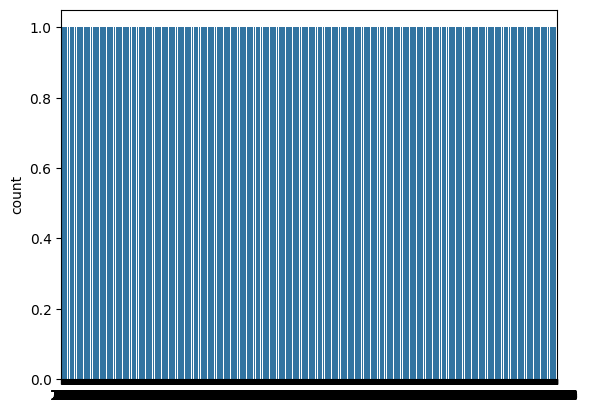

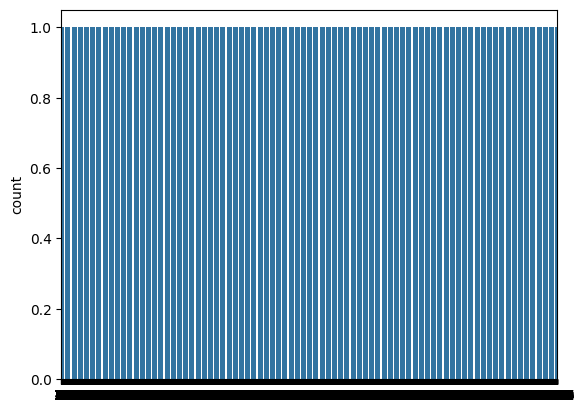

In [55]:
gen_len_distplot(resamp_neut, 0)
gen_len_distplot(upped_dict['neut'], 1)

Counter({7: 1298, 6: 1121, 8: 1073, 5: 844, 9: 815, 10: 563, 4: 416, 11: 287, 3: 165, 12: 155, 13: 67, 2: 40, 14: 16, 1: 4, 16: 2, 15: 1})
Counter({7: 1961, 6: 1645, 8: 1550, 5: 1230, 9: 1169, 10: 800, 4: 593, 11: 412, 3: 231, 12: 224, 13: 98, 2: 56, 14: 24, 1: 4, 16: 2, 15: 1})


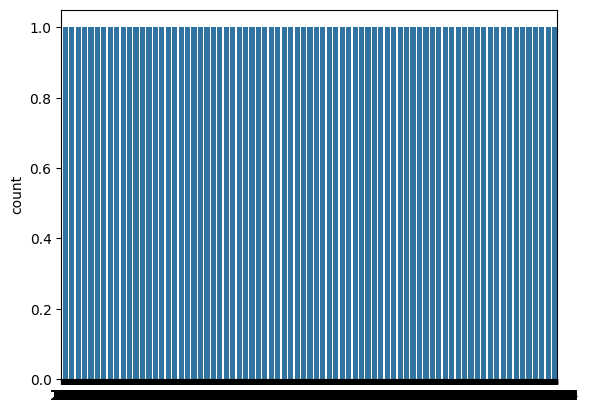

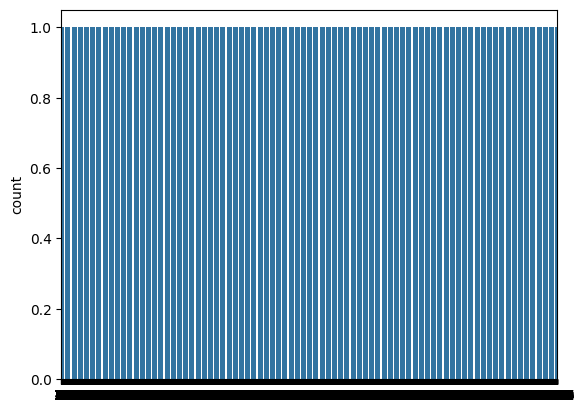

In [56]:
gen_len_distplot(resamp_news, 0)
gen_len_distplot(upped_dict['news'], 1)

Looking pretty similar, checking wordclouds

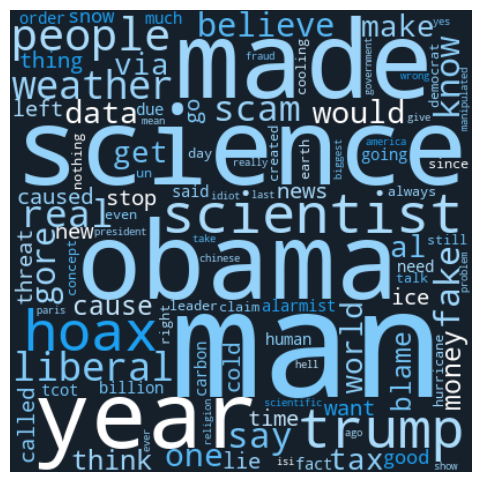

In [45]:
ct_anti = Counter()

upped_dict['anti']['tokens'].apply(ct_anti.update)
#print(cnt)
wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(ct_anti)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

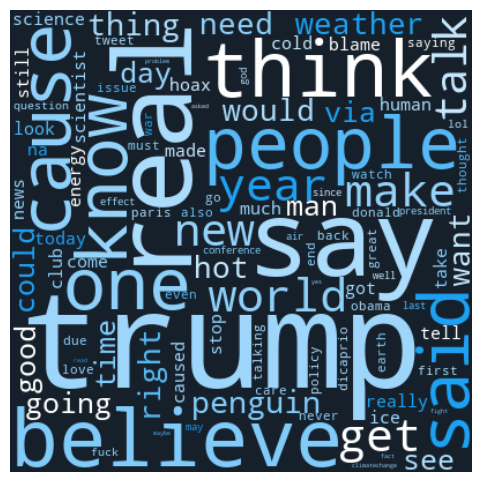

In [46]:
ct_neut = Counter()
    

    
upped_dict['neut']['tokens'].apply(ct_neut.update)
#print(cnt)
wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(ct_neut)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

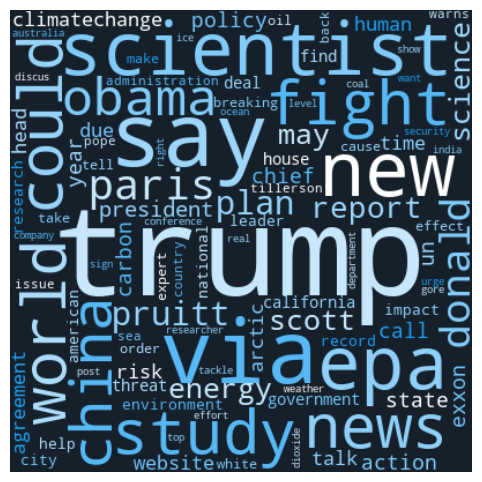

In [47]:
ct_news = Counter()    
upped_dict['news']['tokens'].apply(ct_news.update)
#print(cnt)
wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(ct_news)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Look similar to original data, good to work with

In [48]:
##stitch them back together
samp = pd.concat(frames)

rcounts = pd.DataFrame(samp.groupby('target')['message'].count())
total = rcounts.message.sum()

rcounts['percentage'] = round(100* (rcounts['message']/total))
rcounts['label'] = rcounts.index
print(rcounts)

        message  percentage  label
target                            
0         10000        25.0      0
1         10000        25.0      1
2         10000        25.0      2
3         10000        25.0      3


Text(0.5, 1.0, 'Balanced Training Data')

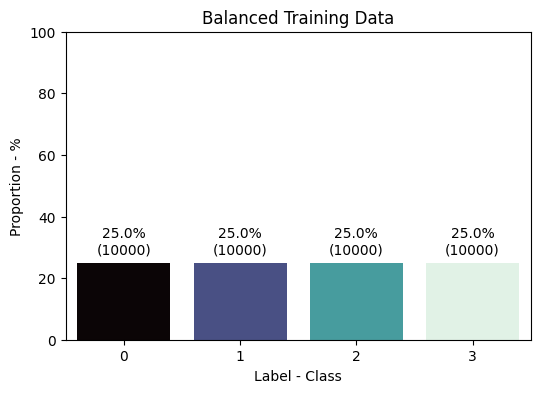

In [49]:
plt.figure(figsize=(6, 4))
g = sns.barplot(x = 'label', y = 'percentage',  data = rcounts, palette = 'mako', legend=False, hue='label')
g.set_ylim(0,100)

c = 0

for p in g.patches:
    txt = str(p.get_height().round()) + '%\n(' + str(rcounts.message[c]) + ')'
    txt_x = p.get_x() + 0.4
    txt_y = p.get_height() + 3
    g.text(txt_x, txt_y, txt, ha = 'center')
    
    c += 1

plt.ylabel('Proportion - %')
plt.xlabel('Label - Class')
plt.title('Balanced Training Data')

## 11. Vectorization

Now that we have pre-processed the data, we need to convert the text into a format that can be used by machine learning algorithms. We will use the TF-IDF vectorizer to convert the text into a matrix of TF-IDF features.

In [50]:
tfidf = TfidfVectorizer(analyzer = 'word',
                        max_features = 1500,
                        min_df = 3)
          #              ngram_range = (1,2)) cant use ngrams with upsampled data
tr_feats = tfidf.fit_transform(samp['clean_message'])
tr_feats.shape
r_train_X = samp['target'].values
r_train_y = tr_feats

In [51]:
print(tr_feats.shape)
print(r_train_X.shape)
print(r_train_y.shape)

(40000, 1500)
(40000,)
(40000, 1500)
